# Installing Libraries

In [1]:
!pip install torchsummary
!pip install torch-lr-finder
!pip install cuda-python

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.

# Import Libraries

In [2]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

# Albumentation - Transformations


In [3]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

train_mean=[0.4914, 0.4822, 0.4471]
train_std=[0.2469, 0.2433, 0.2615]

class Album_train():
    def __init__(self):
        self.albumentations_transform = A.Compose([
                        A.Normalize(mean=train_mean, std=train_std),
                        A.PadIfNeeded(min_height=36, min_width=36, p=1),
                        A.RandomCrop(32, 32, p=1),
                        A.HorizontalFlip(p=0.5),
                    #     A.ShiftScaleRotate(p=0.5),
                        A.CoarseDropout(max_holes = 1, max_height=8, max_width=8, min_holes = 1, min_height=8,
                                        min_width=8, fill_value=train_mean, mask_fill_value = None),
                        ToTensorV2(),
                    ])
    def __call__(self,img):
        img = np.array(img)
        img = self.albumentations_transform(image=img)['image']
        return img

class Album_test():
    def __init__(self):
        self.albumentations_transform = A.Compose([
                        A.Normalize(mean=train_mean, std=train_std),
                        ToTensorV2(),
                    ])

    def __call__(self,img):
        img = np.array(img)
        img = self.albumentations_transform(image=img)['image']
        return img

# Dataset defining

In [4]:
train = datasets.CIFAR10('./Data',
                            train=True,
                            transform=Album_train(),
                            download=True)

test = datasets.CIFAR10('./Data',
                                train=False,
                                transform=Album_test(),
                                download=True)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 170498071/170498071 [00:46<00:00, 3678800.04it/s]


Extracting ./Data/cifar-10-python.tar.gz to ./Data
Files already downloaded and verified


# Dataloader Arguments & Test/Train Dataloaders


In [5]:
SEED = 1

cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
# Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create.
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=2, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? False


In [6]:
import model
import utilities

from model import *
from utilities import *

ModuleNotFoundError: No module named 'model'

## Plotting Random train images

In [ ]:
# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

show_images(train_loader)
show_images(train_loader)

# Model Summary


In [ ]:
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(3, 32, 32))

# Train and Test of our model

In [ ]:
from torch_lr_finder import LRFinder
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-7, weight_decay=1e-2)
lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
lr_finder.range_test(train_loader, end_lr=10, num_iter=100)
lr_finder.plot() # to inspect the loss-learning rate graph
lr_finder.reset() # to reset the model and optimizer to their initial state

In [10]:
from torch.optim.lr_scheduler import StepLR

train_losses = []
test_losses = []
train_acc = []
test_acc = []
lrs = []

MAX_EPOCHS = 24

optimizer = optim.Adam(model.parameters(), lr=5.21E-04, weight_decay=1e-2)
scheduler = optim.lr_scheduler.OneCycleLR(optimizer,
                                          max_lr=5.21E-04,
                                          pct_start=0.2,
                                          epochs=MAX_EPOCHS,
                                          div_factor=100.0,
                                          final_div_factor=100.0,
                                          steps_per_epoch=len(train_loader))


for epoch in range(MAX_EPOCHS):
    print("EPOCH:", epoch + 1 )

    train(model, device, train_loader, optimizer, scheduler, train_losses, train_acc, lrs)
    test(model, device, test_loader,test_losses, test_acc)

EPOCH: 1


Loss=1.3076003789901733 Batch_id=390 Accuracy=37.87: 100%|██████████| 391/391 [00:25<00:00, 15.34it/s]



Test set: Average loss: 1.2669, Accuracy: 5467/10000 (54.67%)

EPOCH: 2


Loss=1.1567212343215942 Batch_id=390 Accuracy=59.63: 100%|██████████| 391/391 [00:24<00:00, 16.07it/s]



Test set: Average loss: 1.0761, Accuracy: 6196/10000 (61.96%)

EPOCH: 3


Loss=0.7485784292221069 Batch_id=390 Accuracy=70.62: 100%|██████████| 391/391 [00:23<00:00, 16.42it/s]



Test set: Average loss: 0.7396, Accuracy: 7460/10000 (74.60%)

EPOCH: 4


Loss=0.646325945854187 Batch_id=390 Accuracy=76.19: 100%|██████████| 391/391 [00:28<00:00, 13.64it/s]



Test set: Average loss: 0.6797, Accuracy: 7685/10000 (76.85%)

EPOCH: 5


Loss=0.6043896675109863 Batch_id=390 Accuracy=79.14: 100%|██████████| 391/391 [00:24<00:00, 16.14it/s]



Test set: Average loss: 0.7783, Accuracy: 7417/10000 (74.17%)

EPOCH: 6


Loss=0.4062563478946686 Batch_id=390 Accuracy=80.98: 100%|██████████| 391/391 [00:24<00:00, 16.07it/s]



Test set: Average loss: 0.5472, Accuracy: 8127/10000 (81.27%)

EPOCH: 7


Loss=0.533082127571106 Batch_id=390 Accuracy=82.20: 100%|██████████| 391/391 [00:24<00:00, 16.02it/s]



Test set: Average loss: 0.5781, Accuracy: 8028/10000 (80.28%)

EPOCH: 8


Loss=0.4966437816619873 Batch_id=390 Accuracy=82.77: 100%|██████████| 391/391 [00:25<00:00, 15.54it/s]



Test set: Average loss: 0.6255, Accuracy: 7865/10000 (78.65%)

EPOCH: 9


Loss=0.4286044239997864 Batch_id=390 Accuracy=83.37: 100%|██████████| 391/391 [00:24<00:00, 16.02it/s]



Test set: Average loss: 0.7185, Accuracy: 7546/10000 (75.46%)

EPOCH: 10


Loss=0.5825061798095703 Batch_id=390 Accuracy=83.81: 100%|██████████| 391/391 [00:24<00:00, 16.02it/s]



Test set: Average loss: 0.6173, Accuracy: 7831/10000 (78.31%)

EPOCH: 11


Loss=0.2615755796432495 Batch_id=390 Accuracy=84.22: 100%|██████████| 391/391 [00:24<00:00, 15.98it/s]



Test set: Average loss: 0.4819, Accuracy: 8357/10000 (83.57%)

EPOCH: 12


Loss=0.4767814576625824 Batch_id=390 Accuracy=85.00: 100%|██████████| 391/391 [00:24<00:00, 15.91it/s]



Test set: Average loss: 0.5017, Accuracy: 8360/10000 (83.60%)

EPOCH: 13


Loss=0.4391631484031677 Batch_id=390 Accuracy=85.79: 100%|██████████| 391/391 [00:24<00:00, 16.07it/s]



Test set: Average loss: 0.5670, Accuracy: 8045/10000 (80.45%)

EPOCH: 14


Loss=0.36762508749961853 Batch_id=390 Accuracy=86.74: 100%|██████████| 391/391 [00:24<00:00, 16.13it/s]



Test set: Average loss: 0.5155, Accuracy: 8237/10000 (82.37%)

EPOCH: 15


Loss=0.4731537699699402 Batch_id=390 Accuracy=87.71: 100%|██████████| 391/391 [00:24<00:00, 16.18it/s]



Test set: Average loss: 0.4782, Accuracy: 8460/10000 (84.60%)

EPOCH: 16


Loss=0.36912137269973755 Batch_id=390 Accuracy=89.03: 100%|██████████| 391/391 [00:24<00:00, 15.72it/s]



Test set: Average loss: 0.4327, Accuracy: 8572/10000 (85.72%)

EPOCH: 17


Loss=0.3184274435043335 Batch_id=390 Accuracy=90.09: 100%|██████████| 391/391 [00:25<00:00, 15.63it/s]



Test set: Average loss: 0.3176, Accuracy: 8964/10000 (89.64%)

EPOCH: 18


Loss=0.36694401502609253 Batch_id=390 Accuracy=91.66: 100%|██████████| 391/391 [00:24<00:00, 15.68it/s]



Test set: Average loss: 0.2866, Accuracy: 9051/10000 (90.51%)

EPOCH: 19


Loss=0.31174689531326294 Batch_id=390 Accuracy=93.00: 100%|██████████| 391/391 [00:25<00:00, 15.49it/s]



Test set: Average loss: 0.2675, Accuracy: 9092/10000 (90.92%)

EPOCH: 20


Loss=0.2082529067993164 Batch_id=390 Accuracy=94.43: 100%|██████████| 391/391 [00:25<00:00, 15.44it/s]



Test set: Average loss: 0.2477, Accuracy: 9176/10000 (91.76%)

EPOCH: 21


Loss=0.20637726783752441 Batch_id=390 Accuracy=95.33: 100%|██████████| 391/391 [00:25<00:00, 15.46it/s]



Test set: Average loss: 0.2245, Accuracy: 9260/10000 (92.60%)

EPOCH: 22


Loss=0.19571521878242493 Batch_id=390 Accuracy=96.38: 100%|██████████| 391/391 [00:25<00:00, 15.52it/s]



Test set: Average loss: 0.2156, Accuracy: 9289/10000 (92.89%)

EPOCH: 23


Loss=0.1126699224114418 Batch_id=390 Accuracy=96.95: 100%|██████████| 391/391 [00:24<00:00, 15.76it/s]



Test set: Average loss: 0.2127, Accuracy: 9288/10000 (92.88%)

EPOCH: 24


Loss=0.06069617718458176 Batch_id=390 Accuracy=97.25: 100%|██████████| 391/391 [00:24<00:00, 15.85it/s]



Test set: Average loss: 0.2125, Accuracy: 9305/10000 (93.05%)



In [11]:
train_losses1 = [t.cpu().item() for t in train_losses]

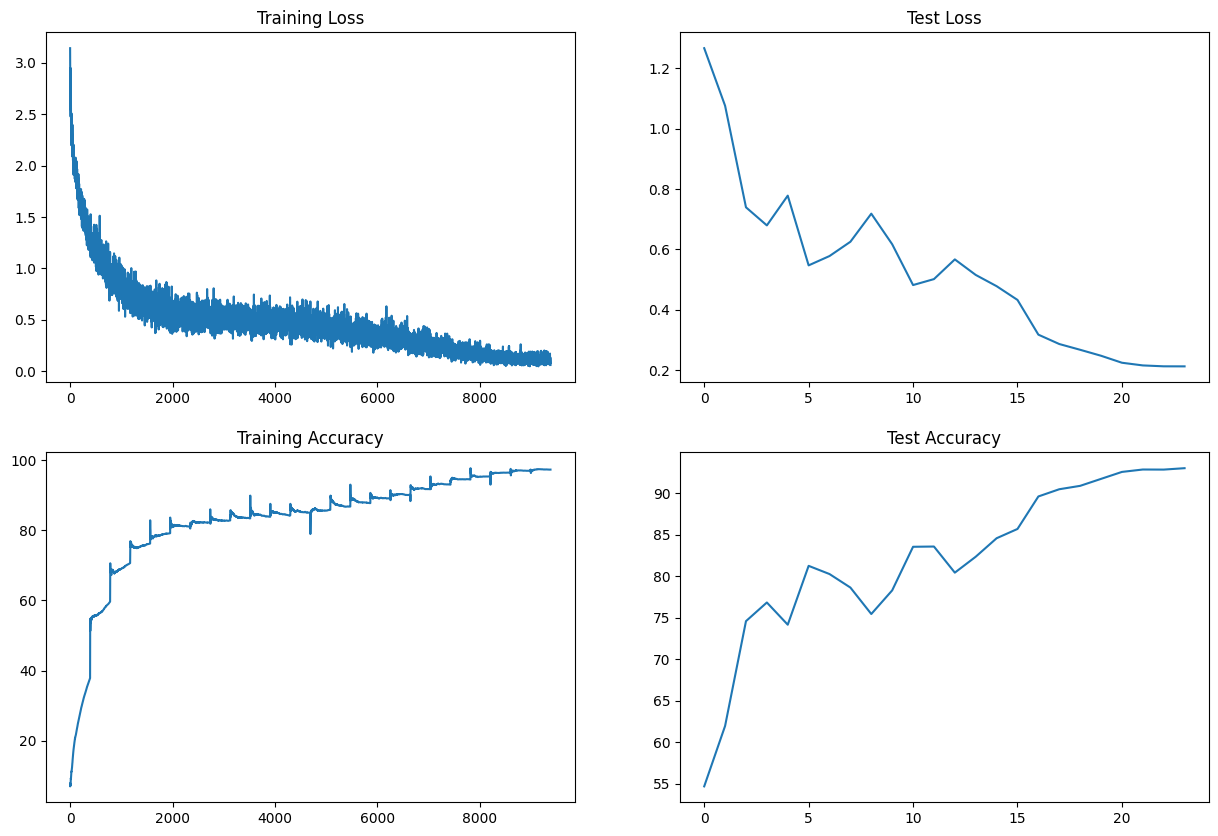

In [12]:
print_graph(train_losses1,train_acc, test_losses,test_acc)

In [13]:
wrong_prediction_list = []
model.eval()
for images, labels in test_loader:
    images, labels = images.to(device), labels.to(device)
    output = model(images)
    pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    match = pred.eq(labels.view_as(pred)).to('cpu').numpy()
    for j, i in enumerate(match):
        if(i == False):
            wrong_prediction_list.append((images[j], pred[j].item(), labels[j].item()))

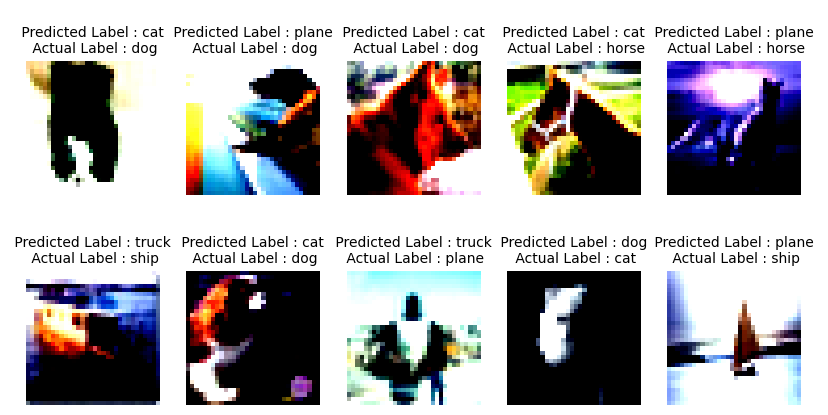

In [14]:
display_incorrect_images(wrong_prediction_list, n=10 )